# 05Tools: Model Explainability - Feature-Based

Model explainability helps understand model outputs = predictions.  There are two approaches here:
- Feature-Based Explanations - columns/features attributions
    - How much did each feature contribute to a specific prediction
    - Uses a baseline for comparison, usually based on a central value for each feature from the training data
    - Helpful for recognizing bias and finding areas for improvement
    - Read more about [feature attributions and methods](https://cloud.google.com/vertex-ai/docs/explainable-ai/overview#feature_attributions)
    - Examples in [github.com/GoogleClouPlatform/vertex-ai-samples](https://github.com/GoogleCloudPlatform/vertex-ai-samples/tree/main/notebooks/official/explainable_ai)
- Example-Based Explanations - row/example attributions
    - Return similar examples from training data, neighbors, to help understand predictions
    - Along with a prediction, get examples from the source data that are most similar to the prediction to further understand "why?"
    
This notebook covers feature-based explanations.  For a review of example-based explanations see the notebook [05Tools - Explainability - Example-Based.ipynb](./05Tools%20-%20Explainability%20-%20Example-Based.ipynb).
    
Vertex AI can serve explanations during online and batch predictions.  

### Prerequisites:
-  At least 1 of the notebooks in this series [05, 05a-05i]
    - these each create a model, add it to the Vertex AI Model Registry, and update a Vertex AI Endpoint for the series

### Conceptual Flow & Workflow
<p align="center">
  <img alt="Conceptual Flow" src="../architectures/slides/05tools_explain_arch.png" width="45%">
&nbsp; &nbsp; &nbsp; &nbsp;
  <img alt="Workflow" src="../architectures/slides/05tools_explain_console.png" width="45%">
</p>

---
## Setup

inputs:

In [1]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [2]:
REGION = 'us-central1'
EXPERIMENT = '05_explanability'
SERIES = '05'

# source data
BQ_PROJECT = PROJECT_ID
BQ_DATASET = 'fraud'
BQ_TABLE = 'fraud_prepped'

# Resources
DEPLOY_COMPUTE = 'n1-standard-4'
DEPLOY_IMAGE='us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-7:latest'

# Model Training
VAR_TARGET = 'Class'
VAR_OMIT = 'transaction_id' # add more variables to the string with space delimiters

packages:

In [3]:
from google.cloud import aiplatform
from google.cloud import bigquery

import tensorflow as tf

from datetime import datetime
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value
import json
import numpy as np

clients:

In [4]:
aiplatform.init(project=PROJECT_ID, location=REGION)
bq = bigquery.Client()

parameters:

In [5]:
BUCKET = PROJECT_ID
DIR = f"temp/{EXPERIMENT}"

In [138]:
SERVICE_ACCOUNT = !gcloud config list --format='value(core.account)' 
SERVICE_ACCOUNT = SERVICE_ACCOUNT[0]
SERVICE_ACCOUNT

'1026793852137-compute@developer.gserviceaccount.com'

List the service accounts current roles:

In [139]:
!gcloud projects get-iam-policy $PROJECT_ID --filter="bindings.members:$SERVICE_ACCOUNT" --format='table(bindings.role)' --flatten="bindings[].members"

ROLE
roles/bigquery.admin
roles/owner
roles/run.admin
roles/storage.objectAdmin


>Note: If the resulting list is missing [roles/storage.objectAdmin](https://cloud.google.com/storage/docs/access-control/iam-roles) then [revisit the setup notebook](../00%20-%20Setup/00%20-%20Environment%20Setup.ipynb#permissions) and add this permission to the service account with the provided instructions.

environment:

In [7]:
!rm -rf {DIR}
!mkdir -p {DIR}

---
## Get Vertex AI Endpoint And Deployed Model

In [8]:
endpoints = aiplatform.Endpoint.list(filter = f"labels.series={SERIES}")
if endpoints:
    endpoint = endpoints[0]
    print(f"Endpoint Exists: {endpoints[0].resource_name}")
else:
    print(f"There does not appear to be an endpoint for SERIES = {SERIES}")

Endpoint Exists: projects/1026793852137/locations/us-central1/endpoints/1961322035766362112


In [9]:
endpoint.display_name

'05'

In [10]:
model = aiplatform.Model(
    model_name = endpoint.list_models()[0].model+f'@{endpoint.list_models()[0].model_version_id}'
)

In [11]:
model.display_name

'05_05h'

In [12]:
model.versioned_resource_name

'projects/1026793852137/locations/us-central1/models/model_05_05h@1'

In [13]:
model.uri

'gs://statmike-mlops-349915/05/05h/models/20220927230247/6/model'

---
## Retrieve Records For Prediction & Explanation

In [14]:
n = 1000
pred = bq.query(query = f"SELECT * FROM {BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE} WHERE splits='TEST' LIMIT {n}").to_dataframe()

In [15]:
pred.head(4)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,transaction_id,splits
0,35337,1.092844,-0.013230,1.359829,2.731537,-0.707357,0.873837,-0.796130,0.437707,0.396770,...,-0.167647,0.027557,0.592115,0.219695,0.036970,0.010984,0.0,0,a1b10547-d270-48c0-b902-7a0f735dadc7,TEST
1,60481,1.238973,0.035226,0.063003,0.641406,-0.260893,-0.580097,0.049938,-0.034733,0.405932,...,-0.057718,0.104983,0.537987,0.589563,-0.046207,-0.006212,0.0,0,814c62c8-ade4-47d5-bf83-313b0aafdee5,TEST
2,139587,1.870539,0.211079,0.224457,3.889486,-0.380177,0.249799,-0.577133,0.179189,-0.120462,...,0.180776,-0.060226,-0.228979,0.080827,0.009868,-0.036997,0.0,0,d08a1bfa-85c5-4f1b-9537-1c5a93e6afd0,TEST
3,162908,-3.368339,-1.980442,0.153645,-0.159795,3.847169,-3.516873,-1.209398,-0.292122,0.760543,...,-1.171627,0.214333,-0.159652,-0.060883,1.294977,0.120503,0.0,0,802f3307-8e5a-4475-b795-5d5d8d7d0120,TEST


Remove columns not included as features in the model:

In [16]:
newobs = pred[pred.columns[~pred.columns.isin(VAR_OMIT.split()+[VAR_TARGET, 'splits'])]].to_dict(orient='records')
#newobs[0]

In [17]:
len(newobs)

1000

---
## Feature-Based Explanations

In Vertex AI you [configure explanations](https://cloud.google.com/vertex-ai/docs/explainable-ai/configuring-explanations-feature-based) by providing an `explanationSpec`. For feature-based explanations this can be done when registering the model in the Model Registry.  You can also set, or override, the `explanationSpec` when deploying models to and endpoints or configuring batch predictions jobs.


### ExplanationSpec

From the [Python client for Vertex AI](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform), the `explanationSpec` is provided by two input parameters: `explanation_parameters` and `explanation_metadata`.  The parameters must be passed together and can be set (or overwritten):
- When registering the model in the Vertex AI Model Registry:
    - https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Model#google_cloud_aiplatform_Model_upload
- When deploying a model the a Vertex AI Endpoint for online serving:
    - https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Endpoint#google_cloud_aiplatform_Endpoint_deploy
- When creating a Vertex AI Batch Prediciton Job:
    - https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.BatchPredictionJob#google_cloud_aiplatform_BatchPredictionJob_create


#### Explanation Parameters

The [Explanation Parameters](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform_v1.types.ExplanationParameters) included setting the method of attribution along with associated parameters for the method.  A review of methods can be found [here](https://cloud.google.com/vertex-ai/docs/explainable-ai/overview#compare-methods).

In [18]:
explanation_parameters = aiplatform.explain.ExplanationParameters({'integrated_gradients_attribution': {'step_count': 50}})
explanation_parameters

integrated_gradients_attribution {
  step_count: 50
}

#### Explanation Metadata

The [Explanation Metadata](https://cloud.google.com/vertex-ai/docs/reference/rest/v1beta1/ExplanationSpec#explanationmetadata) specifys the inputs metadata and outputs metadata.  For a TensorFlow model there is a tool for building the explanation metadata as used below:
- This is documented here: https://googleapis.dev/python/aiplatform/latest/index.html#explainable-ai-get-metadata


In [19]:
from google.cloud.aiplatform.explain.metadata.tf.v2 import saved_model_metadata_builder
builder = saved_model_metadata_builder.SavedModelMetadataBuilder(model.uri)
explanation_metadata = builder.get_metadata_protobuf()

2022-09-28 13:36:19.042586: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2299995000 Hz
2022-09-28 13:36:19.043060: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55d7e726de50 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-09-28 13:36:19.043096: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-09-28 13:36:19.043428: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [20]:
explanation_metadata

inputs {
  key: "Amount"
  value {
    input_tensor_name: "Amount"
  }
}
inputs {
  key: "Time"
  value {
    input_tensor_name: "Time"
  }
}
inputs {
  key: "V1"
  value {
    input_tensor_name: "V1"
  }
}
inputs {
  key: "V10"
  value {
    input_tensor_name: "V10"
  }
}
inputs {
  key: "V11"
  value {
    input_tensor_name: "V11"
  }
}
inputs {
  key: "V12"
  value {
    input_tensor_name: "V12"
  }
}
inputs {
  key: "V13"
  value {
    input_tensor_name: "V13"
  }
}
inputs {
  key: "V14"
  value {
    input_tensor_name: "V14"
  }
}
inputs {
  key: "V15"
  value {
    input_tensor_name: "V15"
  }
}
inputs {
  key: "V16"
  value {
    input_tensor_name: "V16"
  }
}
inputs {
  key: "V17"
  value {
    input_tensor_name: "V17"
  }
}
inputs {
  key: "V18"
  value {
    input_tensor_name: "V18"
  }
}
inputs {
  key: "V19"
  value {
    input_tensor_name: "V19"
  }
}
inputs {
  key: "V2"
  value {
    input_tensor_name: "V2"
  }
}
inputs {
  key: "V20"
  value {
    input_tensor_name: "V2

### Create/Retrieve An Endpoint

In [21]:
endpoints = aiplatform.Endpoint.list(filter = f"labels.series={SERIES}")
if endpoints:
    endpoint = endpoints[0]
    print(f"Endpoint Exists: {endpoints[0].resource_name}")
else:
    endpoint = aiplatform.Endpoint.create(
        display_name = f"{SERIES}",
        labels = {'series' : f"{SERIES}"}  
    )
    print(f"Endpoint Created: {endpoint.resource_name}")   

print(f'Review the Endpoint in the Console:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/endpoints/{endpoint.name}?project={PROJECT_ID}')

Endpoint Exists: projects/1026793852137/locations/us-central1/endpoints/1961322035766362112
Review the Endpoint in the Console:
https://console.cloud.google.com/vertex-ai/locations/us-central1/endpoints/1961322035766362112?project=statmike-mlops-349915


In [22]:
endpoint.display_name

'05'

### Deploy Model To Endpoint
At the top of this notebook a current endpoint was used to retrieve the model currently deployed.  This model was then used to create the explanations metadata.  In the cell below the same model is deployed again with 100% of traffic, this time with explanations metadata.  This demonstrates that the `explanationSpec` can be provided with the model upload to the Model Registry or at the point of model use for Endponts or Batch Prediction Jobs. 

In [23]:
endpoint.deploy(
    model = model,
    deployed_model_display_name = model.display_name,
    traffic_percentage = 100,
    machine_type = DEPLOY_COMPUTE,
    min_replica_count = 1,
    max_replica_count = 1,
    explanation_parameters = explanation_parameters,
    explanation_metadata = explanation_metadata
) 

Deploying Model projects/1026793852137/locations/us-central1/models/model_05_05h to Endpoint : projects/1026793852137/locations/us-central1/endpoints/1961322035766362112
Deploy Endpoint model backing LRO: projects/1026793852137/locations/us-central1/endpoints/1961322035766362112/operations/1833451376076652544
Endpoint model deployed. Resource name: projects/1026793852137/locations/us-central1/endpoints/1961322035766362112


### Remove Deployed Models without Traffic

In [24]:
for deployed_model in endpoint.list_models():
    if deployed_model.id in endpoint.traffic_split:
        print(f"Model {deployed_model.display_name} with version {deployed_model.model_version_id} has traffic = {endpoint.traffic_split[deployed_model.id]}")
    else:
        endpoint.undeploy(deployed_model_id = deployed_model.id)
        print(f"Undeploying {deployed_model.display_name} with version {deployed_model.model_version_id} because it has no traffic.")

Undeploying Endpoint model: projects/1026793852137/locations/us-central1/endpoints/1961322035766362112
Undeploy Endpoint model backing LRO: projects/1026793852137/locations/us-central1/endpoints/1961322035766362112/operations/578072979947126784
Endpoint model undeployed. Resource name: projects/1026793852137/locations/us-central1/endpoints/1961322035766362112
Undeploying 05_05h with version 1 because it has no traffic.
Model 05_05h with version 1 has traffic = 100


In [36]:
endpoint.traffic_split

{'6805735083375329280': 100}

In [37]:
endpoint.list_models()[0]

id: "6805735083375329280"
model: "projects/1026793852137/locations/us-central1/models/model_05_05h"
display_name: "05_05h"
create_time {
  seconds: 1664372324
  nanos: 791849000
}
dedicated_resources {
  machine_spec {
    machine_type: "n1-standard-4"
  }
  min_replica_count: 1
  max_replica_count: 1
}
explanation_spec {
  parameters {
    integrated_gradients_attribution {
      step_count: 50
    }
  }
  metadata {
    inputs {
      key: "Amount"
      value {
        input_tensor_name: "Amount"
      }
    }
    inputs {
      key: "Time"
      value {
        input_tensor_name: "Time"
      }
    }
    inputs {
      key: "V1"
      value {
        input_tensor_name: "V1"
      }
    }
    inputs {
      key: "V10"
      value {
        input_tensor_name: "V10"
      }
    }
    inputs {
      key: "V11"
      value {
        input_tensor_name: "V11"
      }
    }
    inputs {
      key: "V12"
      value {
        input_tensor_name: "V12"
      }
    }
    inputs {
      key: "V

### Get Prediction: Python Client

In [38]:
instances = [json_format.ParseDict(newobs[0], Value())]

In [39]:
prediction = endpoint.predict(instances = instances)
prediction

Prediction(predictions=[[0.999359429, 0.000640570885]], deployed_model_id='6805735083375329280', model_version_id='1', model_resource_name='projects/1026793852137/locations/us-central1/models/model_05_05h', explanations=None)

In [40]:
prediction.predictions[0]

[0.999359429, 0.000640570885]

In [41]:
np.argmax(prediction.predictions[0])

0

### Get Prediction & Explanation: Python Client

In [42]:
explanation = endpoint.explain(instances = instances)

In [43]:
explanation.predictions

[[0.999359429, 0.000640570885]]

In [44]:
explanation.explanations

[attributions {
  baseline_output_value: 0.9998088479042053
  instance_output_value: 0.9993594288825989
  feature_attributions {
    struct_value {
      fields {
        key: "Amount"
        value {
          number_value: 0.0
        }
      }
      fields {
        key: "Time"
        value {
          number_value: -0.0004143236672609398
        }
      }
      fields {
        key: "V1"
        value {
          number_value: 0.0006397598038975461
        }
      }
      fields {
        key: "V10"
        value {
          number_value: 0.0001342498056633324
        }
      }
      fields {
        key: "V11"
        value {
          number_value: 0.000174347379359924
        }
      }
      fields {
        key: "V12"
        value {
          number_value: 0.0006407510412684659
        }
      }
      fields {
        key: "V13"
        value {
          number_value: -0.0001414391462321943
        }
      }
      fields {
        key: "V14"
        value {
          number_v

In [45]:
print("attribution:")
print("baseline output:",explanation.explanations[0].attributions[0].baseline_output_value)
print("instance output:",explanation.explanations[0].attributions[0].instance_output_value)
print("output_index:",explanation.explanations[0].attributions[0].output_index)
print("output_name:",explanation.explanations[0].attributions[0].output_name)
print("approximation error:",explanation.explanations[0].attributions[0].approximation_error)

attribution:
baseline output: 0.9998088479042053
instance output: 0.9993594288825989
output_index: [0]
output_name: prediction_layer
approximation error: 0.03523130529533971


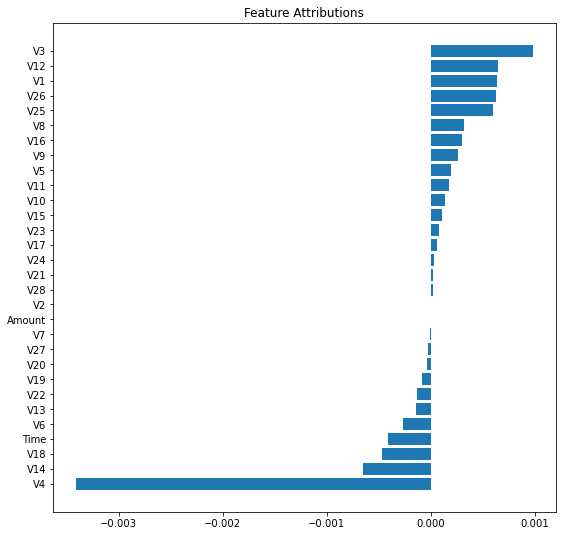

In [46]:
import matplotlib.pyplot as plt
features = []
scores = []
for k in explanation.explanations[0].attributions[0].feature_attributions:
    features.append(k)
    scores.append(explanation.explanations[0].attributions[0].feature_attributions[k])
features = [x for _, x in sorted(zip(scores, features))]
scores = sorted(scores)
fig, ax = plt.subplots()
fig.set_size_inches(9, 9)
ax.barh(features, scores)
plt.title('Feature Attributions')
fig.show()

In the plot above, each bar represents the attribution for a feature, or how much the feature affected the change in the predicted value relative to the baseline value.

In [47]:
sum_attributions = 0
for k in explanation.explanations[0].attributions[0].feature_attributions:
    sum_attributions += explanation.explanations[0].attributions[0].feature_attributions[k]

print("baseline output:",explanation.explanations[0].attributions[0].baseline_output_value)
print("instance output:",explanation.explanations[0].attributions[0].instance_output_value)
print("Total Attribution:", sum_attributions)
print("instance - baseline:",explanation.explanations[0].attributions[0].instance_output_value-explanation.explanations[0].attributions[0].baseline_output_value)

baseline output: 0.9998088479042053
instance output: 0.9993594288825989
Total Attribution: -0.0004652529926752473
instance - baseline: -0.0004494190216064453


### Explainable AI SDK: Local Explanations
When using Vertex AI Workbench based user-managed notebooks you have access to the [Explainable AI SDK](https://github.com/GoogleCloudPlatform/explainable_ai_sdk).  This section demonstrates local explanations using the SDK.

This can be helpful for iterating on setting up explanations before deploying the model with `explanationSpec`:
- try different baselines
- setup vizualization settings for image models
- adjust parameters like steps (integrated gradients) or paths (sampled Shapley)

In [48]:
import explainable_ai_sdk
from explainable_ai_sdk.metadata.tf.v2 import SavedModelMetadataBuilder

In [49]:
builder = SavedModelMetadataBuilder(model.uri)
builder.save_model_with_metadata(f'{DIR}/model')
!ls -l -R {DIR}/model

INFO:tensorflow:Assets written to: temp/05_explanability/model/assets


INFO:tensorflow:Assets written to: temp/05_explanability/model/assets


temp/05_explanability/model:
total 516
drwxr-xr-x 2 jupyter jupyter   4096 Sep 28 14:04 assets
-rw-r--r-- 1 jupyter jupyter   3541 Sep 28 14:04 explanation_metadata.json
-rw-r--r-- 1 jupyter jupyter 513837 Sep 28 14:04 saved_model.pb
drwxr-xr-x 2 jupyter jupyter   4096 Sep 28 14:04 variables

temp/05_explanability/model/assets:
total 0

temp/05_explanability/model/variables:
total 52
-rw-r--r-- 1 jupyter jupyter 45865 Sep 28 14:04 variables.data-00000-of-00001
-rw-r--r-- 1 jupyter jupyter  2122 Sep 28 14:04 variables.index


In [50]:
local_model = explainable_ai_sdk.load_model_from_local_path(
    model_path = f'{DIR}/model',
    config = explainable_ai_sdk.IntegratedGradientsConfig(step_count = 50)
)

In [51]:
type(local_model)

explainable_ai_sdk.model.local_model.LocalModel

In [52]:
newobs[0]

{'Time': 35337,
 'V1': 1.0928441854981998,
 'V2': -0.0132303486713432,
 'V3': 1.35982868199426,
 'V4': 2.7315370965921004,
 'V5': -0.707357349219652,
 'V6': 0.8738370029866129,
 'V7': -0.7961301510622031,
 'V8': 0.437706509544851,
 'V9': 0.39676985012996396,
 'V10': 0.587438102569443,
 'V11': -0.14979756231827498,
 'V12': 0.29514781622888103,
 'V13': -1.30382621882143,
 'V14': -0.31782283120234495,
 'V15': -2.03673231037199,
 'V16': 0.376090905274179,
 'V17': -0.30040350116459497,
 'V18': 0.433799615590844,
 'V19': -0.145082264348681,
 'V20': -0.240427548108996,
 'V21': 0.0376030733329398,
 'V22': 0.38002620963091405,
 'V23': -0.16764742731151097,
 'V24': 0.0275573495476881,
 'V25': 0.59211469704354,
 'V26': 0.219695164116351,
 'V27': 0.0369695108704894,
 'V28': 0.010984441006191,
 'Amount': 0.0}

Update the dictionary to have values as tensors:

In [53]:
{key: tf.constant([value], dtype=tf.float64, name = key) for key, value in newobs[0].items()}

{'Time': <tf.Tensor: shape=(1,), dtype=float64, numpy=array([35337.])>,
 'V1': <tf.Tensor: shape=(1,), dtype=float64, numpy=array([1.09284419])>,
 'V2': <tf.Tensor: shape=(1,), dtype=float64, numpy=array([-0.01323035])>,
 'V3': <tf.Tensor: shape=(1,), dtype=float64, numpy=array([1.35982868])>,
 'V4': <tf.Tensor: shape=(1,), dtype=float64, numpy=array([2.7315371])>,
 'V5': <tf.Tensor: shape=(1,), dtype=float64, numpy=array([-0.70735735])>,
 'V6': <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.873837])>,
 'V7': <tf.Tensor: shape=(1,), dtype=float64, numpy=array([-0.79613015])>,
 'V8': <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.43770651])>,
 'V9': <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.39676985])>,
 'V10': <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.5874381])>,
 'V11': <tf.Tensor: shape=(1,), dtype=float64, numpy=array([-0.14979756])>,
 'V12': <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.29514782])>,
 'V13': <tf.Tensor: shape=(1,), dtype

In [54]:
prediction = local_model.predict(instances = [{key: tf.constant([value], dtype=tf.float64, name = key) for key, value in newobs[0].items()}])
prediction

[{'prediction_layer': [0.9993594288825989, 0.0006405712338164449]}]

In [55]:
explanation = local_model.explain(instances = [{key: tf.constant([value], dtype=tf.float64, name = key) for key, value in newobs[0].items()}])
explanation

In [56]:
explanation[0].feature_importance()

{'V25': 0.0005942574935033917,
 'V16': 0.0002946223539765924,
 'Amount': 0.0,
 'V12': 0.000632787065114826,
 'V13': -0.00013942852092441171,
 'V24': 2.878528721339535e-05,
 'V11': 0.00017123982252087444,
 'V18': -0.00046487952931784093,
 'V17': 5.348947524907999e-05,
 'Time': -0.000414342968724668,
 'V21': 2.1111720343469642e-05,
 'V6': -0.0002565783797763288,
 'V19': -8.281596092274413e-05,
 'V4': -0.0033756685443222523,
 'V9': 0.00025864268536679447,
 'V8': 0.00032356404699385166,
 'V3': 0.0009668276179581881,
 'V22': -0.00013087713159620762,
 'V7': -1.4244606063584797e-05,
 'V28': 1.6581458112341352e-05,
 'V10': 0.00013023441715631634,
 'V27': -2.443306948407553e-05,
 'V26': 0.0006148662068881094,
 'V1': 0.0006281811511144042,
 'V15': 0.00011165279283886775,
 'V5': 0.00019089323177468032,
 'V14': -0.0006501245661638677,
 'V2': 2.9484260721801547e-07,
 'V23': 8.100857667159289e-05,
 'V20': -4.009165058960207e-05}

In [57]:
explanation[0].as_tensors()

{'V25': array([0.00059426], dtype=float32),
 'V16': array([0.00029462], dtype=float32),
 'Amount': array([0.], dtype=float32),
 'V12': array([0.00063279], dtype=float32),
 'V13': array([-0.00013943], dtype=float32),
 'V24': array([2.8785287e-05], dtype=float32),
 'V11': array([0.00017124], dtype=float32),
 'V18': array([-0.00046488], dtype=float32),
 'V17': array([5.3489475e-05], dtype=float32),
 'Time': array([-0.00041434], dtype=float32),
 'V21': array([2.111172e-05], dtype=float32),
 'V6': array([-0.00025658], dtype=float32),
 'V19': array([-8.281596e-05], dtype=float32),
 'V4': array([-0.00337567], dtype=float32),
 'V9': array([0.00025864], dtype=float32),
 'V8': array([0.00032356], dtype=float32),
 'V3': array([0.00096683], dtype=float32),
 'V22': array([-0.00013088], dtype=float32),
 'V7': array([-1.4244606e-05], dtype=float32),
 'V28': array([1.6581458e-05], dtype=float32),
 'V10': array([0.00013023], dtype=float32),
 'V27': array([-2.443307e-05], dtype=float32),
 'V26': array([

Label Index 0
Example Score: 0.9994
Baseline Score: 0.9998
Approximation Error: 0.0557


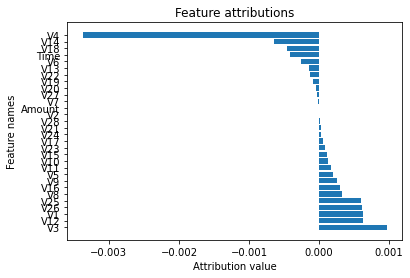

In [58]:
explanation[0].visualize_attributions()

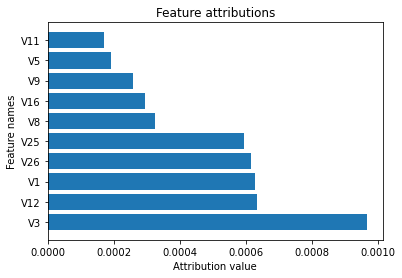

In [60]:
explanation[0].visualize_top_k_features(k = 10) #(k=len(newobs[0]))

### Explainable AI SDK With Vertex AI Endpoints
The features of the Explainable AI SDK are also useful for Vertex AI Endpoints.  The example below shows using the SDK with a Vertex AI Endpoint, the one setup in this notebook with `explanationSpec`.

In [61]:
vertex_explain = explainable_ai_sdk.load_model_from_vertex(
    project = PROJECT_ID,
    region = REGION,
    endpoint_id = endpoint.resource_name.split('/')[-1]
)

In [62]:
prediction = vertex_explain.predict(instances = [newobs[0]])
prediction

{'predictions': [[0.999359429, 0.000640570885]],
 'deployedModelId': '6805735083375329280',
 'model': 'projects/1026793852137/locations/us-central1/models/model_05_05h',
 'modelDisplayName': '05_05h',
 'modelVersionId': '1'}

In [63]:
explanation = vertex_explain.explain(instances = [newobs[0]])

In [64]:
explanation[0].feature_importance()

{'V19': -8.451229505264931e-05,
 'V6': -0.0002639915953797813,
 'V3': 0.000978733840666455,
 'V4': -0.003410509122983224,
 'V16': 0.0002993777337902293,
 'V2': 2.986267834960175e-07,
 'V7': -1.192395122762306e-05,
 'V25': 0.0005967866046822927,
 'V21': 2.146126095026355e-05,
 'Time': -0.0004143236672609398,
 'V11': 0.000174347379359924,
 'V13': -0.0001414391462321943,
 'V14': -0.0006570217975484478,
 'V12': 0.0006407510412684659,
 'V1': 0.0006397598038975461,
 'V23': 8.197118969563011e-05,
 'V9': 0.0002646862996948276,
 'V5': 0.0001936723056144693,
 'V28': 1.668037729654176e-05,
 'V27': -2.528044072544735e-05,
 'V10': 0.0001342498056633324,
 'V20': -3.987095442887504e-05,
 'V15': 0.0001053083690454626,
 'V8': 0.0003230462107611755,
 'V24': 2.954450205502484e-05,
 'V17': 5.495992449653278e-05,
 'V22': -0.0001292469343209725,
 'V26': 0.0006247391878798962,
 'V18': -0.0004675075511166591}

In [65]:
explanation[0].as_tensors()

{'V19': array(-8.45122951e-05),
 'V6': array(-0.00026399),
 'V3': array(0.00097873),
 'V4': array(-0.00341051),
 'V16': array(0.00029938),
 'V2': array(2.98626783e-07),
 'V7': array(-1.19239512e-05),
 'V25': array(0.00059679),
 'V21': array(2.1461261e-05),
 'Time': array(-0.00041432),
 'V11': array(0.00017435),
 'V13': array(-0.00014144),
 'V14': array(-0.00065702),
 'V12': array(0.00064075),
 'V1': array(0.00063976),
 'V23': array(8.19711897e-05),
 'V9': array(0.00026469),
 'V5': array(0.00019367),
 'V28': array(1.66803773e-05),
 'V27': array(-2.52804407e-05),
 'V10': array(0.00013425),
 'V20': array(-3.98709544e-05),
 'V15': array(0.00010531),
 'V8': array(0.00032305),
 'V24': array(2.95445021e-05),
 'V17': array(5.49599245e-05),
 'V22': array(-0.00012925),
 'V26': array(0.00062474),
 'V18': array(-0.00046751)}

In [66]:
explanation[0].visualize_attributions()

Label Index [0]
Example Score: 0.9994
Baseline Score: 0.9998
Approximation Error: 0.0352


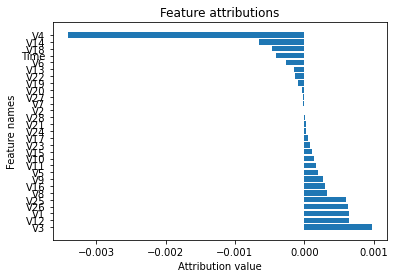

In [67]:
explanation[0].visualize_top_k_features(k=len(newobs[0]))

---
## Example-Based Explanations